In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sounddevice as sd
import librosa

import matplotlib.pyplot as plt
import numpy as np
import math

import os

import array
import scipy
import numpy as np
from pydub import AudioSegment
from pydub.utils import get_array_type

# DATA_DIR = os.path.join("data" , "old_guitar_sample")
DATA_DIR = os.path.join("data" , "guitar_sample")

In [5]:
def fft(f):
    Ni = len(f)
    Mi = int(Ni / 2)
    if Mi <= 2:
        return [f[0] + f[1] + f[2] + f[3], 
               f[0] - 1j*f[1] - f[2] + 1j*f[3],
               f[0] - f[1] + f[2] - f[3],
               f[0] + 1j*f[1] - f[2] - 1j*f[3]]
    
    wn = math.cos(2*math.pi/Ni) - 1j*math.sin(2*math.pi/Ni)
    fe = [f[i] for i in range(Ni) if i % 2 == 0]
    fo = [f[i] for i in range(Ni) if i % 2 == 1]
    Fe = fft(fe)
    Fo = fft(fo)
    return [np.around(Fe[i] + (wn**i)*Fo[i], decimals=10) for i in range(Mi)] + [np.around(Fe[i] - (wn**i)*Fo[i], decimals=10) for i in range(Mi)]

def get_pressed(f, spectrum):
    fh = [329, 247, 196, 147, 110, 82]
    notes = ["EH", "B", "G", "D", "A", "EL"]
    
    f, spectrum = zip(*sorted(zip(f, spectrum), key=lambda x: x[1], reverse=True))
    f1 = f[0]
    f2 = None
    for fi in f:
        if abs(fi - f1) >= 200:
            f2 = fi
            break
    
#     print(np.array(f)[np.array(spectrum).argsort()[::-1]][:10])
    f1, f2 = min(f1, f2), max(f1, f2)
    rows, _ = zip(*sorted(zip([i for i in range(len(fh))], [abs(f1 - fi) for fi in fh]), key=lambda x: x[1]))
    row = rows[0]
    
    print(f'  Frequencies detected {notes[row]}[{row}]: {f1}Hz, {f2}Hz.', min(f))
    return notes[row]
        
def get_audio_data(filename=None, quiet=True):
    fs = 2**12 # sample rate
    tp = 2 # sampling duration
    N = n = fs*tp # number of samples
    
    # Extract data and sampling rate from file
    recording, fs = librosa.load(filename, sr=fs, duration=tp)
    recording = recording.reshape((-1, 1))

    n = len(recording)        
    tp = int(n / fs)

    if tp < 2:
        pad_width = N - recording.shape[0]
        recording = np.pad(recording, pad_width=((0, pad_width), (0, 0)), mode='constant')

        n = len(recording)
        tp = int(n / fs)

    N = fs*tp # number of samples
    x = [round(float(recording[i]), 10) for i in range(n)] # input sequence
    return x, tp, n

def get_frequency_amplitude(x, tp, N):
    _X = fft(x) # discrete Fourier transform
    X = [round(Xi/N, 10) for Xi in _X] # frequency spectrum
    X_amp = [np.absolute(Xi) for Xi in X] # amplitude spectrum

    M = int(N/2)
    ti = [i*tp/N for i in range(N)]
    fi = [i/tp for i in range(M)]
    X_amp = np.array(X_amp[:M])*2
    
    return ti, fi, X_amp

def extract_features2(file_name):
    try:
        song = AudioSegment.from_file(file_name)
        features = np.array(frequency_spectrum(song))
        print(features.shape)

    except Exception as e:
        print("Error encountered while parsing file: ", file_name, e)
        return None 
     
    return features

def frequency_spectrum(sample, max_frequency=800):
    """
    Derive frequency spectrum of a signal pydub.AudioSample
    Returns an array of frequencies and an array of how prevelant that frequency is in the sample
    """
    # Convert pydub.AudioSample to raw audio data
    # Copied from Jiaaro's answer on https://stackoverflow.com/questions/32373996/pydub-raw-audio-data
    bit_depth = sample.sample_width * 8
    array_type = get_array_type(bit_depth)
    raw_audio_data = array.array(array_type, sample._data)
    n = len(raw_audio_data)

    # Compute FFT and frequency value for each index in FFT array
    # Inspired by Reveille's answer on https://stackoverflow.com/questions/53308674/audio-frequencies-in-python
    freq_array = np.arange(n) * (float(sample.frame_rate) / n)  # two sides frequency range
    freq_array = freq_array[: (n // 2)]  # one side frequency range

    raw_audio_data = raw_audio_data - np.average(raw_audio_data)  # zero-centering
    freq_magnitude = scipy.fft.fft(raw_audio_data)  # fft computing and normalization
    freq_magnitude = freq_magnitude[: (n // 2)]  # one side

    if max_frequency:
        max_index = int(max_frequency * n / sample.frame_rate) + 1
        freq_array = freq_array[:max_index]
        freq_magnitude = freq_magnitude[:max_index]

    freq_magnitude = abs(freq_magnitude)
    freq_magnitude = freq_magnitude / np.sum(freq_magnitude)
    return freq_array, freq_magnitude

In [6]:
# x, tp, N = get_audio_data()
# print(x[:5], len(x))

In [7]:
filename = os.path.join(DATA_DIR, "0A", "A out tune#27.wav")
# filename = os.path.join(DATA_DIR, "1A", "A sample 17.wav")
filename = os.path.join(DATA_DIR, "1A", "A sample 1.wav")
# filename = "C:\\Users\\christian\\Documents\\christian\\work\\python\\guitar_music_note_recognizer\\media\\1\\sample.wav"

x, tp, N = get_audio_data(filename)
print(x[:5], len(x))

features = extract_features2(filename)
print(features.max(1))

[0.0006707453, 0.0106267091, 0.0102058174, 0.0119427675, 0.0068773152] 8192
(2, 1451)
[7.99542368e+02 9.03221102e-02]


In [8]:
# 8628
N, math.log(N, 2)

(8192, 13.0)

In [9]:
ti, fi, X_amp = get_frequency_amplitude(x, tp, N)

print(f"shape: ti = {len(ti)}, fi = {len(fi)}, X_amp = {len(X_amp)}", max(X_amp))

shape: ti = 8192, fi = 4096, X_amp = 4096 0.023595093546467258


In [10]:
pressed = get_pressed(fi, X_amp)
print(pressed, 'was pressed.')

  Frequencies detected A[4]: 108.5Hz, 434.0Hz. 0.0
A was pressed.


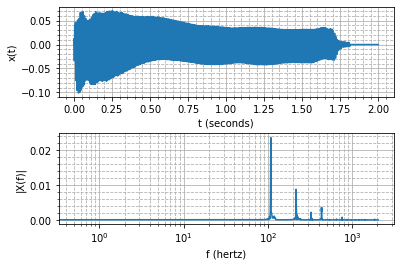

In [11]:
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax1= plt.subplot(211)
plt.plot(ti, x)
plt.xlabel('t (seconds)')
plt.ylabel('x(t)')
plt.minorticks_on()
plt.grid(b=True, which='major', linestyle='-')
plt.grid(b=True, which='minor', linestyle='--')

ax2 = plt.subplot(212)
plt.plot(fi, X_amp)
plt.xlabel('f (hertz)')
plt.ylabel('|X(f)|')
ax2.set_xscale('log')
plt.minorticks_on()
plt.grid(b=True, which='major', linestyle='-')
plt.grid(b=True, which='minor', linestyle='--')

plt.show()

In [12]:
pressed = get_pressed(fi, X_amp)
print(pressed, 'was pressed.')

  Frequencies detected A[4]: 108.5Hz, 434.0Hz. 0.0
A was pressed.


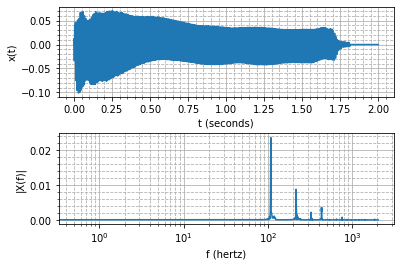

In [13]:
plt.subplots_adjust(wspace=0.4, hspace=0.4)

ax1= plt.subplot(211)
plt.plot(ti, x)
plt.xlabel('t (seconds)')
plt.ylabel('x(t)')
plt.minorticks_on()
plt.grid(b=True, which='major', linestyle='-')
plt.grid(b=True, which='minor', linestyle='--')

ax2 = plt.subplot(212)
plt.plot(fi, X_amp)
plt.xlabel('f (hertz)')
plt.ylabel('|X(f)|')
ax2.set_xscale('log')
plt.minorticks_on()
plt.grid(b=True, which='major', linestyle='-')
plt.grid(b=True, which='minor', linestyle='--')

plt.show()

In [14]:
max(X_amp)

0.023595093546467258

In [15]:
for label in os.listdir(DATA_DIR):
    print(label)
    labeldir= os.path.join(DATA_DIR, label)

    for filename in os.listdir(labeldir):
        filepath = os.path.join(DATA_DIR, label, filename)

        audio_features = get_audio_data(filepath, quiet=True)
        if not audio_features:
            continue

        x, tp, N = audio_features
        ti, fi, X_amp = get_frequency_amplitude(x, tp, N)

        pressed = get_pressed(fi, X_amp)
    #     print(pressed, 'was pressed.')

0A
  Frequencies detected A[4]: 110.0Hz, 330.0Hz. 0.0
  Frequencies detected B[1]: 224.5Hz, 449.5Hz. 0.0
  Frequencies detected A[4]: 118.5Hz, 356.0Hz. 0.0
  Frequencies detected A[4]: 122.5Hz, 367.5Hz. 0.0
  Frequencies detected A[4]: 125.5Hz, 373.5Hz. 0.0
  Frequencies detected D[3]: 131.0Hz, 389.5Hz. 0.0
  Frequencies detected D[3]: 134.5Hz, 405.0Hz. 0.0
  Frequencies detected D[3]: 138.5Hz, 415.0Hz. 0.0
  Frequencies detected D[3]: 134.0Hz, 402.5Hz. 0.0
  Frequencies detected D[3]: 142.0Hz, 429.5Hz. 0.0
  Frequencies detected A[4]: 107.0Hz, 321.5Hz. 0.0
  Frequencies detected B[1]: 257.5Hz, 644.0Hz. 0.0
  Frequencies detected A[4]: 119.5Hz, 359.0Hz. 0.0
  Frequencies detected A[4]: 113.5Hz, 321.5Hz. 0.0
  Frequencies detected G[2]: 199.5Hz, 399.5Hz. 0.0
  Frequencies detected EH[0]: 290.0Hz, 774.5Hz. 0.0
  Frequencies detected B[1]: 248.5Hz, 473.0Hz. 0.0
  Frequencies detected B[1]: 239.5Hz, 482.0Hz. 0.0
  Frequencies detected D[3]: 138.5Hz, 338.5Hz. 0.0
  Frequencies detected D[3]

  Frequencies detected B[1]: 246.0Hz, 736.5Hz. 0.0
  Frequencies detected B[1]: 246.5Hz, 737.0Hz. 0.0
  Frequencies detected B[1]: 246.5Hz, 737.5Hz. 0.0
  Frequencies detected B[1]: 247.0Hz, 735.5Hz. 0.0
  Frequencies detected B[1]: 246.5Hz, 738.0Hz. 0.0
  Frequencies detected B[1]: 246.0Hz, 1227.0Hz. 0.0
  Frequencies detected B[1]: 246.5Hz, 737.5Hz. 0.0
  Frequencies detected B[1]: 246.5Hz, 736.5Hz. 0.0
  Frequencies detected B[1]: 246.5Hz, 737.0Hz. 0.0
  Frequencies detected B[1]: 246.5Hz, 738.0Hz. 0.0
  Frequencies detected B[1]: 247.0Hz, 736.5Hz. 0.0
  Frequencies detected B[1]: 247.0Hz, 736.5Hz. 0.0
1D
  Frequencies detected D[3]: 145.0Hz, 436.0Hz. 0.0
  Frequencies detected D[3]: 145.0Hz, 436.0Hz. 0.0
  Frequencies detected D[3]: 145.0Hz, 436.5Hz. 0.0
  Frequencies detected D[3]: 145.0Hz, 436.0Hz. 0.0
  Frequencies detected D[3]: 145.0Hz, 436.5Hz. 0.0
  Frequencies detected D[3]: 145.0Hz, 436.0Hz. 0.0
  Frequencies detected D[3]: 145.0Hz, 436.0Hz. 0.0
  Frequencies detected D[3]

KeyboardInterrupt: 

In [ ]:
for label in os.listdir(DATA_DIR):
    print(label)
    labeldir= os.path.join(DATA_DIR, label)

    for filename in os.listdir(labeldir):
        filepath = os.path.join(DATA_DIR, label, filename)

        audio_features = get_audio_data(filepath, quiet=True)
        if not audio_features:
            continue

        x, tp, N = audio_features
        ti, fi, X_amp = get_frequency_amplitude(x, tp, N)

        pressed = get_pressed(fi, X_amp)
    #     print(pressed, 'was pressed.')

In [ ]:
np.log2(4096)